Using old locations on f before gel labels and complete locating at the bottom.

	1. Load particle trajectories
        [+] does this need to be converted into...wahtever that other format was (stacked or some name I gave it...I forget)
	2. Decompose into para/perp shear directions
        [+] convince myself that the rotation code is working as expected.
        [ ] compute local strain for larger nnb cutoff (say 2\sigma) and modify the strain code to allow for more nnb in padding computation.
        [ ] decompose into para/perp strain by rotating the computed strain tensor
	3. Carry out stress/strain analysis with decreasing cutoff on nnb (averaging)
         
        - drop particles with insufficient number of nnbs
        - rotate the already computed strains through the rotation matrix.
	4. Find high von Mises 
    5. Diagonalize local strains
        - fix the error I mentinoed in the one note notebook about this having to do with what eigenvector I was rotating about in Rodrigues formula 
          (ie choose eigenvector with zero eigenvalue or maybe middle eigenvalue, not sure). 
    6. Cluster the high strain regions (and check with ovito)
        - This should be done with scipy and simple graph connected component
        - compute the adjaceny matrix for all the high strain points. (ij entry is true if node i is within distance cutoff of node j, and false otherwise)
        - then connected componenent remembering that the graph is undirected
    7. Average over a cluster of high von Mises strain.
        - is the strain diagonalization inside the core give you the same direction of direction of maximum shear?
        - what if the number of particles included in the strain measure increases. 
Basically, cluster, align and avg the strains.

In [1]:
# preamble
import numpy as np
import numba

import sys
sys.path.extend(['/Users/zsolt/Colloid_git/TractionRheoscopy'])
from data_analysis import static as da
from data_analysis import grid_track, rotation
import pandas as pd
import yaml
from importlib import reload
import seaborn as sns

## 1. Load the particles and change formats if necessary

In [2]:
# load sed and gel
# By default this loads from 
# Also the memory footprint of this is too large. (90 stacks, 900k particles, and 24Gb, and keys for positions and uncertainities)
"""
path = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/'
fNameDict = {'sedPos': 'tfrGel10212018A_shearRun10292018f_sed_stitched_pandas.h5',
                     'sedStrain_traj': 'tfrGel10212018A_shearRun10292018f_sed_strainTrajZeroRef.h5',
                     'gelPos': 'tfrGel10212018A_shearRun10292018f_gel_stitched_pandas.h5',
                     'eigen' : 'tfrGel10212018A_shearRun10292018f_{}.h5'.format('eigenStrain_decomposition'),
                     'sedStrain_rot' : 'tfrGel10212018A_shearRun10292018f_{}.h5'.format('sedStrain_paraX_perpY')
                     }
"""
expt_dict = da.loadExperiment()

In [3]:
sedPos, sedStrain_traj, gelPos = expt_dict['sedPos'], expt_dict['sedStrain_traj'], expt_dict['gelPos']

In [6]:
sedPos

x (um, imageStack)  y (um, imageStack)  z (um, imageStack)  \
frame particle                                                               
0     0                  23.480112            2.221875           27.385583   
      1                  31.531264            2.180390           27.351286   
      2                  37.789111            2.119240           27.275850   
      3                  39.408522            2.436315           27.277841   
      4                  35.347537            2.748365           27.335966   
...                            ...                 ...                 ...   
89    1489977           200.492249          221.169243           71.848828   
      1489978           187.204307          202.418158           83.305471   
      1489979           188.845862          225.415862           83.684483   
      1489980           193.989494          194.780281           83.924158   
      1489981           186.063189          201.029539           85.103917   

                        x_std          y_std          z_std  
frame particle                                               
0     0              0.160625       0.149919       0.139626  
      1              0.121123       0.120859       0.108598  
      2              0.130098       0.134635       0.117372  
      3              0.110703       0.114330       0.101162  
      4              0.134831       0.134550       0.121837  
...                       ...            ...            ...  
89    1489977        0.121115       0.122348       0.104224  
      1489978             NaN            NaN            NaN  
      1489979        1.279382       0.922309       1.188493  
      1489980   119852.822302  111242.080747  128126.585762  
      1489981             NaN            NaN            NaN  

[87508017 rows x 6 columns]

In [11]:
sedStrain_traj.head(12)

(0,1)     (0,2)     (0,3)     (0,4)     (0,5)  (0,6)  \
particle values                                                               
1        D2_min     0.091007  0.151544  0.160599  0.112302  0.089856    NaN   
         exx        0.011591 -0.038838 -0.029463 -0.019457 -0.016845    NaN   
         exy       -0.010121 -0.003519 -0.015082 -0.020948  0.003042    NaN   
         exz       -0.007984 -0.009392 -0.014228  0.012680 -0.003678    NaN   
         eyy        0.008537 -0.004854 -0.010697 -0.037893 -0.034701    NaN   
         eyz        0.004810  0.000332  0.007940  0.012433 -0.014893    NaN   
         ezz        0.044463  0.038127  0.052124  0.024388  0.031323    NaN   
         rxy       -0.002290 -0.001991 -0.010641 -0.007947  0.002880    NaN   
         rxz        0.004448  0.009475  0.007487 -0.007799  0.009499    NaN   
         ryz        0.000674 -0.022097 -0.014815 -0.012095 -0.006611    NaN   
         nnb count  6.000000  6.000000  6.000000  5.000000  5.000000    NaN   
4        D2_min     0.072556  0.039182  0.069349       NaN       NaN    NaN   

                    (0,7)  (0,8)  (0,9)  (0,10)  ...  (0,80)  (0,81)  (0,82)  \
particle values                                  ...                           
1        D2_min       NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         exx          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         exy          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         exz          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         eyy          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         eyz          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         ezz          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         rxy          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         rxz          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         ryz          NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
         nnb count    NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   
4        D2_min       NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   

                    (0,83)  (0,84)  (0,85)  (0,86)  (0,87)  (0,88)  (0,89)  
particle values                                                             
1        D2_min        NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         exx           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         exy           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         exz           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         eyy           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         eyz           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         ezz           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         rxy           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         rxz           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         ryz           NaN     NaN     NaN     NaN     NaN     NaN     NaN  
         nnb count     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4        D2_min        NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[12 rows x 89 columns]

In [12]:
sedStrain_traj

(0,1)     (0,2)     (0,3)     (0,4)     (0,5)  \
particle values                                                        
1        D2_min     0.091007  0.151544  0.160599  0.112302  0.089856   
         exx        0.011591 -0.038838 -0.029463 -0.019457 -0.016845   
         exy       -0.010121 -0.003519 -0.015082 -0.020948  0.003042   
         exz       -0.007984 -0.009392 -0.014228  0.012680 -0.003678   
         eyy        0.008537 -0.004854 -0.010697 -0.037893 -0.034701   
...                      ...       ...       ...       ...       ...   
966620   ezz       -0.013288 -0.075770 -0.091173 -0.001066 -0.057880   
         rxy       -0.010417 -0.030309 -0.033643 -0.005564 -0.013235   
         rxz        0.001705  0.037192  0.035942 -0.004599  0.042057   
         ryz       -0.001611  0.023254  0.016176  0.003832  0.002946   
         nnb count  9.000000  9.000000  9.000000  9.000000  9.000000   

                       (0,6)     (0,7)     (0,8)     (0,9)  (0,10)  ...  \
particle values                                                     ...   
1        D2_min          NaN       NaN       NaN       NaN     NaN  ...   
         exx             NaN       NaN       NaN       NaN     NaN  ...   
         exy             NaN       NaN       NaN       NaN     NaN  ...   
         exz             NaN       NaN       NaN       NaN     NaN  ...   
         eyy             NaN       NaN       NaN       NaN     NaN  ...   
...                      ...       ...       ...       ...     ...  ...   
966620   ezz       -0.046463 -0.045701 -0.024680 -0.037661     NaN  ...   
         rxy       -0.021210 -0.023903 -0.033713 -0.032682     NaN  ...   
         rxz        0.026707  0.065915  0.060764  0.054993     NaN  ...   
         ryz        0.010033  0.022470  0.007448  0.016059     NaN  ...   
         nnb count  9.000000  8.000000  7.000000  7.000000     NaN  ...   

                    (0,80)  (0,81)  (0,82)  (0,83)  (0,84)  (0,85)  (0,86)  \
particle values                                                              
1        D2_min        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         exx           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         exy           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         exz           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         eyy           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                    ...     ...     ...     ...     ...     ...     ...   
966620   ezz           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         rxy           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         rxz           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         ryz           NaN     NaN     NaN     NaN     NaN     NaN     NaN   
         nnb count     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                    (0,87)  (0,88)  (0,89)  
particle values                             
1        D2_min        NaN     NaN     NaN  
         exx           NaN     NaN     NaN  
         exy           NaN     NaN     NaN  
         exz           NaN     NaN     NaN  
         eyy           NaN     NaN     NaN  
...                    ...     ...     ...  
966620   ezz           NaN     NaN     NaN  
         rxy           NaN     NaN     NaN  
         rxz           NaN     NaN     NaN  
         ryz           NaN     NaN     NaN  
         nnb count     NaN     NaN     NaN  

[10555985 rows x 89 columns]

In [14]:
%%time
# convert trajectory format to frameParticle format
sedStrain_tmp = sedStrain_traj.transpose().stack('particle')
idx = sedStrain_tmp.index.set_names(['frame','particle'])
sedStrain_frameParticle = pd.DataFrame(sedStrain_tmp, index = idx)
sedStrain_frameParticle

CPU times: user 37.3 s, sys: 23.1 s, total: 1min
Wall time: 1min 8s


values             D2_min       exx       exy       exz       eyy       eyz  \
frame  particle                                                               
(0,1)  1         0.091007  0.011591 -0.010121 -0.007984  0.008537  0.004810   
       4         0.072556  0.004609  0.000526 -0.010615 -0.007425 -0.015354   
       7         0.068485 -0.002058 -0.000601 -0.003270 -0.004937 -0.020609   
       8         0.123259 -0.003628 -0.002255  0.003940 -0.009127 -0.000940   
       12        0.263317 -0.008424 -0.002495  0.003048  0.009275 -0.013323   
...                   ...       ...       ...       ...       ...       ...   
(0,89) 966608    0.599882  0.028857  0.010630 -0.058179  0.022753  0.013150   
       966609    2.120843 -0.014212  0.049120  0.031294  0.021256  0.073846   
       966611    0.386537 -0.000219 -0.003213  0.022503 -0.006216  0.003287   
       966612    0.359476  0.003795 -0.016597 -0.000576  0.012263  0.015917   
       966614    0.625155 -0.011404  0.000857 -0.001301  0.008125  0.021885   

values                ezz  nnb count       rxy       rxz       ryz  
frame  particle                                                     
(0,1)  1         0.044463        6.0 -0.002290  0.004448  0.000674  
       4        -0.031272        6.0  0.002729 -0.003001  0.014332  
       7        -0.001219        9.0 -0.005521  0.004756 -0.010854  
       8         0.029012       11.0 -0.013784  0.002774 -0.000732  
       12       -0.084368        8.0  0.002554 -0.013346  0.023345  
...                   ...        ...       ...       ...       ...  
(0,89) 966608    0.051486        7.0  0.017736 -0.035023 -0.021668  
       966609    0.038145        8.0  0.077705  0.027482 -0.021541  
       966611   -0.005890       15.0  0.000467  0.004727  0.003028  
       966612    0.025330       15.0 -0.000943 -0.008652  0.005424  
       966614    0.002325       15.0  0.020613  0.015556  0.030392  

[82166583 rows x 11 columns]

In [25]:
# make this into a function...note already did this
def traj2fp(strain_traj):
    tmp = strain_traj.transpose().stack('particle')
    idx = tmp.index.set_names(['frame','particle'])
    return pd.DataFrame(tmp, index = idx)

## 2. Decompose in para/perp shear coordinates.

### [+] Convince myself that the rotation code I have written works

In [ ]:
# I have to reconvince myself that the rotation code is working as it should. 
# Acid test is to compare:
#     a. particle position in imageStack 
#            -> compute local strain (with da.makeLocalStrainTraj) 
#            -> rotate strain by degree alpha (with rotation._rotate() and some legwork on converting pandas to np) 
#            -> and some other matrix transform for imageStack to rheoSedHeight (pass a different rotation matrix to rotation._rotate() )
#     b. particle positions in (imageStack) 
#            -> convert to rheoSedHeight (with rotation.coordTransform) 
#            -> rotate position vectors about origin some degrees alpha (with rotation.rotatePosition)
#            -> compute the local strain (with da.makeLocalStrainTraj
#     

In [23]:
%%time
# So now let's carry out a for a single pair (ref, cur) say (0,5)
refCur = np.array([(0,5)])

# I feel like I wrote a function a while back that allows me to pass a list of time points (say [(3,7), (4,6), (48,73)] and compute the strain across those time points.
# if so, where is it and how do I call it?

sedStrain_traj = da.makeLocalStrainTraj(sedPos, refCur)

CPU times: user 2min 21s, sys: 4.37 s, total: 2min 25s
Wall time: 2min 25s


In [26]:
sedStrain_fp = da.traj2frameParticle(sedStrain_traj)

In [27]:
sedStrain_fp

values            D2_min       exx       exy       exz       eyy       eyz  \
frame particle                                                               
(0,1) 0         0.176064  0.016755 -0.005082  0.009494 -0.010655 -0.033047   
      1         0.091007  0.011591 -0.010121 -0.007984  0.008537  0.004810   
      4         0.072556  0.004609  0.000526 -0.010615 -0.007425 -0.015354   
      5         0.040587  0.009429  0.004548  0.008993  0.001632 -0.015434   
      6         0.097879  0.016534  0.014678  0.029575  0.009987  0.016708   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.111493  0.002173  0.001961  0.016498 -0.000121 -0.011342   
      966612    0.052589  0.001354 -0.002099  0.004159 -0.000051 -0.000594   
      966614    0.153511 -0.010092 -0.000476 -0.000072  0.000722  0.002126   
      966616    0.161229  0.007133 -0.007727  0.009461  0.000360 -0.007884   
      966620    0.604725 -0.013956  0.008199 -0.032758  0.004624  0.016816   

values               ezz  nnb count       rxy       rxz       ryz  
frame particle                                                     
(0,1) 0        -0.009595        5.0  0.014384 -0.013840 -0.032983  
      1         0.044463        6.0 -0.002290  0.004448  0.000674  
      4        -0.031272        6.0  0.002729 -0.003001  0.014332  
      5        -0.008182        7.0 -0.002809 -0.005726  0.003943  
      6        -0.015747        7.0  0.005199  0.018496 -0.006296  
...                  ...        ...       ...       ...       ...  
(0,5) 966611   -0.000057       15.0  0.000314  0.005084  0.001945  
      966612   -0.002616       15.0  0.003532  0.002213 -0.005146  
      966614   -0.007655       15.0  0.006466  0.003851  0.013915  
      966616   -0.001363       10.0  0.004697  0.001382  0.017611  
      966620   -0.057880        9.0 -0.013235  0.042057  0.002946  

[1917041 rows x 11 columns]

In [15]:
# load the rotation matrix in the metaData

# load data analysis metaData
meta_path = '/Users/zsolt/Colloid_git/TractionRheoscopy/metaDataYAML/tfrGel10212018A_shearRun10292018f_metaData.yaml'
meta = grid_track.loadMetaData(meta_path,'data_analysis')
meta.keys()

dict_keys(['grid', 'rotation'])

In [18]:
meta['rotation']

{'description': 'This is rotation matrix to rotate image coordinates in rheo_sedHeight coordinate system to coordinates in which the shear direction is along the x direction The coordinate system it assumes is listed under the key coordStr If it is rheo_sedHeight, this coordinate system is just a reflection of the y-axis from the image coordinate system so that it is right handed (ie right handed with z point up into the sample and x to the right, where as the image coordinate system is the array indexing with x being the fasted index, y pointing down, and z going up into the sample.)\n',
 'tracer': {'description': 'This is the manual tracking of a particle clearly on the TEM grid over a few time points\n',
  'coordStr': '(um, imageCoord)',
  'position': [[], []],
  'time_list': [[0, 10, 30, 40, 50, 60, 70]]},
 'rotationMatrix': {'coordStr': '(um, rheo_sedHeight)',
  'handed': 'right',
  'positiveSignature': 'clockwise',
  'units': 'degrees',
  'theta_x': 0,
  'theta_y': 0,
  'theta_z'

In [16]:
rotDict = rotation.parseRotYaml(meta['rotation']['rotationMatrix'])
r_left = rotDict['prod_zyx (left)']
r_left

array([[ 0.99974261, -0.02268733,  0.        ],
       [ 0.02268733,  0.99974261,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [31]:
%%time
# now rotate the strain by alpha 
_sig_np = np.array([(0,0), (0,1), (0,2), (1,1), (1,2), (2,2)])
rot_np_r_left = rotation._rotate(sedStrain_fp[['exx','exy','exz','eyy','eyz','ezz']].to_numpy(), _sig_np, r_left )
rot_df_r_left = pd.DataFrame(data=rot_np_r_left, index=sedStrain_fp.index, columns= ['exx','exy','exz','eyy','eyz','ezz']).join(sedStrain_fp[['nnb count','D2_min']])

CPU times: user 4.59 s, sys: 86 ms, total: 4.68 s
Wall time: 4.65 s


In [32]:
rot_df_r_left

exx       exy       exz       eyy       eyz       ezz  \
frame particle                                                               
(0,1) 0         0.016971 -0.004455  0.010241 -0.010872 -0.032823 -0.009595   
      1         0.012048 -0.010041 -0.008091  0.008079  0.004627  0.044463   
      4         0.004579  0.000798 -0.010264 -0.007395 -0.015591 -0.031272   
      5         0.009219  0.004721  0.009341  0.001842 -0.015226 -0.008182   
      6         0.015865  0.014811  0.029188  0.010656  0.017375 -0.015747   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.002083  0.002011  0.016751 -0.000031 -0.010965 -0.000057   
      966612    0.001449 -0.002065  0.004172 -0.000146 -0.000500 -0.002616   
      966614   -0.010065 -0.000720 -0.000121  0.000695  0.002124 -0.007655   
      966616    0.007480 -0.007565  0.009637  0.000013 -0.007668 -0.001363   
      966620   -0.014319  0.007769 -0.033131  0.004987  0.016069 -0.057880   

                nnb count    D2_min  
frame particle                       
(0,1) 0               5.0  0.176064  
      1               6.0  0.091007  
      4               6.0  0.072556  
      5               7.0  0.040587  
      6               7.0  0.097879  
...                   ...       ...  
(0,5) 966611         15.0  0.111493  
      966612         15.0  0.052589  
      966614         15.0  0.153511  
      966616         10.0  0.161229  
      966620          9.0  0.604725  

[1917041 rows x 8 columns]

In [33]:
# rotate and apply some other transformation for imageStack 2 rheoSedHeight 
rc_left = r_left @ np.array(((1,0,0),(0,-1,0),(0,0,1)))
tmp = rotation._rotate(sedStrain_fp[['exx','exy','exz','eyy','eyz','ezz']].to_numpy(), _sig_np, rc_left )
rot_df_rc_left = pd.DataFrame(data=tmp, index=sedStrain_fp.index, columns= ['exx','exy','exz','eyy','eyz','ezz']).join(sedStrain_fp[['nnb count','D2_min']])
rot_df_rc_left

exx       exy       exz       eyy       eyz       ezz  \
frame particle                                                               
(0,1) 0         0.016510  0.005698  0.008742 -0.010411  0.033254 -0.009595   
      1         0.011130  0.010180 -0.007873  0.008997 -0.004990  0.044463   
      4         0.004627 -0.000252 -0.010961 -0.007443  0.015109 -0.031272   
      5         0.009632 -0.004367  0.008640  0.001429  0.015634 -0.008182   
      6         0.017196 -0.014514  0.029946  0.009324 -0.016033 -0.015747   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.002261 -0.001907  0.016236 -0.000209  0.011713 -0.000057   
      966612    0.001259  0.002129  0.004145  0.000045  0.000689 -0.002616   
      966614   -0.010108  0.000230 -0.000024  0.000738 -0.002127 -0.007655   
      966616    0.006779  0.007872  0.009279  0.000714  0.008097 -0.001363   
      966620   -0.013575 -0.008612 -0.032368  0.004243 -0.017555 -0.057880   

                nnb count    D2_min  
frame particle                       
(0,1) 0               5.0  0.176064  
      1               6.0  0.091007  
      4               6.0  0.072556  
      5               7.0  0.040587  
      6               7.0  0.097879  
...                   ...       ...  
(0,5) 966611         15.0  0.111493  
      966612         15.0  0.052589  
      966614         15.0  0.153511  
      966616         10.0  0.161229  
      966620          9.0  0.604725  

[1917041 rows x 8 columns]

In [42]:
%%time
# now carry out b
# convert position to rheoSedHeight

_sedPos_rot = rotation.coordTransform(sedPos, '(um, imageStack)', '(um, rheo_sedHeight)')
_sedPos_rot

CPU times: user 1.76 s, sys: 2.06 s, total: 3.82 s
Wall time: 3.82 s


x (um, imageStack)  y (um, imageStack)  z (um, imageStack)  \
frame particle                                                               
0     0                  23.480112            2.221875           27.385583   
      1                  31.531264            2.180390           27.351286   
      2                  37.789111            2.119240           27.275850   
      3                  39.408522            2.436315           27.277841   
      4                  35.347537            2.748365           27.335966   
...                            ...                 ...                 ...   
89    1489977           200.492249          221.169243           71.848828   
      1489978           187.204307          202.418158           83.305471   
      1489979           188.845862          225.415862           83.684483   
      1489980           193.989494          194.780281           83.924158   
      1489981           186.063189          201.029539           85.103917   

                        x_std          y_std          z_std  \
frame particle                                                
0     0              0.160625       0.149919       0.139626   
      1              0.121123       0.120859       0.108598   
      2              0.130098       0.134635       0.117372   
      3              0.110703       0.114330       0.101162   
      4              0.134831       0.134550       0.121837   
...                       ...            ...            ...   
89    1489977        0.121115       0.122348       0.104224   
      1489978             NaN            NaN            NaN   
      1489979        1.279382       0.922309       1.188493   
      1489980   119852.822302  111242.080747  128126.585762   
      1489981             NaN            NaN            NaN   

                x (um, rheo_sedHeight)  y (um, rheo_sedHeight)  \
frame particle                                                   
0     0                     -94.019888              115.278125   
      1                     -85.968736              115.319610   
      2                     -79.710889              115.380760   
      3                     -78.091478              115.063685   
      4                     -82.152463              114.751635   
...                                ...                     ...   
89    1489977                82.992249             -103.669243   
      1489978                69.704307              -84.918158   
      1489979                71.345862             -107.915862   
      1489980                76.489494              -77.280281   
      1489981                68.563189              -83.529539   

                z (um, rheo_sedHeight)  
frame particle                          
0     0                      27.385583  
      1                      27.351286  
      2                      27.275850  
      3                      27.277841  
      4                      27.335966  
...                                ...  
89    1489977                71.848828  
      1489978                83.305471  
      1489979                83.684483  
      1489980                83.924158  
      1489981                85.103917  

[87508017 rows x 9 columns]

In [54]:
%%time
# rotate by alpha
sedPos_rot = rotation.rotatePosition(_sedPos_rot, r_left)
sedPos_rot

CPU times: user 3.4 s, sys: 2.9 s, total: 6.3 s
Wall time: 2.61 s


x (um, rheo_sedHeight)  y (um, rheo_sedHeight)  \
frame particle                                                   
0     0                     -96.611042              113.115392   
      1                     -88.562903              113.339527   
      2                     -82.308053              113.542635   
      3                     -80.681866              113.262381   
      4                     -84.734727              112.858278   
...                                ...                     ...   
89    1489977                85.322866             -101.759686   
      1489978                71.612933              -83.314896   
      1489979                73.775821             -106.269438   
      1489980                78.223090              -75.525047   
      1489981                70.440604              -81.952523   

                z (um, rheo_sedHeight)  
frame particle                          
0     0                      27.385583  
      1                      27.351286  
      2                      27.275850  
      3                      27.277841  
      4                      27.335966  
...                                ...  
89    1489977                71.848828  
      1489978                83.305471  
      1489979                83.684483  
      1489980                83.924158  
      1489981                85.103917  

[87508017 rows x 3 columns]

In [55]:
%%time
# now compute the strain 
reload(da)
sedStrain_rotPos = da.makeLocalStrainTraj(sedPos_rot, refCur, output='frameParticle', pos_keys={'x':'x (um, rheo_sedHeight)', 'y': 'y (um, rheo_sedHeight)', 'z': 'z (um, rheo_sedHeight)'})

CPU times: user 2min 52s, sys: 5.98 s, total: 2min 58s
Wall time: 2min 58s


In [56]:
sedStrain_rotPos

values            D2_min       exx       exy       exz       eyy       eyz  \
frame particle                                                               
(0,1) 0         0.165950  0.016510  0.005698  0.008742 -0.010411  0.033254   
      1         0.100855  0.011130  0.010180 -0.007873  0.008997 -0.004990   
      4         0.074073  0.004627 -0.000252 -0.010961 -0.007443  0.015109   
      5         0.045485  0.009632 -0.004367  0.008640  0.001429  0.015634   
      6         0.117138  0.017196 -0.014514  0.029946  0.009324 -0.016033   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.111101  0.002261 -0.001907  0.016236 -0.000209  0.011713   
      966612    0.057557  0.001259  0.002129  0.004145  0.000045  0.000689   
      966614    0.170842 -0.010108  0.000230 -0.000024  0.000738 -0.002127   
      966616    0.154587  0.006779  0.007872  0.009279  0.000714  0.008097   
      966620    0.664125 -0.013575 -0.008612 -0.032368  0.004243 -0.017555   

values               ezz  nnb count       rxy       rxz       ryz  
frame particle                                                     
(0,1) 0        -0.009595        5.0 -0.014384 -0.014584  0.032660  
      1         0.044463        6.0  0.002290  0.004462 -0.000573  
      4        -0.031272        6.0 -0.002729 -0.002675 -0.014397  
      5        -0.008182        7.0  0.002809 -0.005635 -0.004072  
      6        -0.015747        7.0 -0.005199  0.018348  0.006714  
...                  ...        ...       ...       ...       ...  
(0,5) 966611   -0.000057       15.0 -0.000314  0.005127 -0.001829  
      966612   -0.002616       15.0 -0.003532  0.002096  0.005195  
      966614   -0.007655       15.0 -0.006466  0.004166 -0.013824  
      966616   -0.001363       10.0 -0.004697  0.001781 -0.017575  
      966620   -0.057880        9.0  0.013235  0.042113 -0.001991  

[1917041 rows x 11 columns]

In [47]:
# compare to result from a ()

In [47]:
rot_df_rc_left

exx       exy       exz       eyy       eyz       ezz  \
frame particle                                                               
(0,1) 0         0.016510  0.005698  0.008742 -0.010411  0.033254 -0.009595   
      1         0.011130  0.010180 -0.007873  0.008997 -0.004990  0.044463   
      4         0.004627 -0.000252 -0.010961 -0.007443  0.015109 -0.031272   
      5         0.009632 -0.004367  0.008640  0.001429  0.015634 -0.008182   
      6         0.017196 -0.014514  0.029946  0.009324 -0.016033 -0.015747   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.002261 -0.001907  0.016236 -0.000209  0.011713 -0.000057   
      966612    0.001259  0.002129  0.004145  0.000045  0.000689 -0.002616   
      966614   -0.010108  0.000230 -0.000024  0.000738 -0.002127 -0.007655   
      966616    0.006779  0.007872  0.009279  0.000714  0.008097 -0.001363   
      966620   -0.013575 -0.008612 -0.032368  0.004243 -0.017555 -0.057880   

                nnb count    D2_min  
frame particle                       
(0,1) 0               5.0  0.176064  
      1               6.0  0.091007  
      4               6.0  0.072556  
      5               7.0  0.040587  
      6               7.0  0.097879  
...                   ...       ...  
(0,5) 966611         15.0  0.111493  
      966612         15.0  0.052589  
      966614         15.0  0.153511  
      966616         10.0  0.161229  
      966620          9.0  0.604725  

[1917041 rows x 8 columns]

In [82]:
# identical upto machine precision and some garbage output for low nnb counts when the strain algo is unstable. 
# (however, note that rotating the strain does not do anything to the antisymmetric part of the deformation, but I think that could be rotated in the same way as the strain)
(abs(sedStrain_rotPos['exz'] - rot_df_rc_left['exz']) <0.00000000001).value_counts()

True     1916989
False         52
Name: exz, dtype: int64

In [89]:
sedStrain_rotPos[abs(sedStrain_rotPos['exz'] - rot_df_rc_left['exz']) >0.0000000001].head()

values               D2_min       exx       exy       exz       eyy       eyz  \
frame particle                                                                  
(0,1) 20102      593.527486  1.723141 -1.971046 -1.129149  2.103697  2.488748   
      24279     1308.221123  4.412581  2.959669 -0.930565  0.100695 -0.391264   
      240190     146.728770 -0.820920 -0.352544  0.615527 -1.631907  0.430045   
      269953    3466.999444  0.351980  2.123999 -0.842002 -0.496226 -6.879729   
      270009     308.260173 -0.652505 -0.855176 -1.489370  0.788965  1.121440   

values               ezz  nnb count       rxy       rxz       ryz  
frame particle                                                     
(0,1) 20102    -1.210212        3.0 -0.904839 -0.090035 -0.923006  
      24279    -0.456438        3.0  3.899821  1.732682  0.804111  
      240190   -0.592358        2.0 -0.907168  0.942971 -0.265445  
      269953    2.609356        3.0  1.992885 -0.344265  6.460007  
      270009   -0.091658        3.0  0.909090  1.407141 -1.236513

In [90]:
rot_df_rc_left[abs(sedStrain_rotPos['exz'] - rot_df_rc_left['exz']) >0.0000000001].head()

exx       exy       exz       eyy       eyz       ezz  \
frame particle                                                               
(0,1) 20102     0.371219  0.195090  0.042654 -0.703510 -0.254425  0.039320   
      24279    -0.731726 -0.733206 -0.447966 -1.530640  0.012845  0.097214   
      240190   -1.627365 -0.174479 -0.222156 -1.894764  0.390396 -0.017265   
      269953   -0.016232 -0.089928  0.089083 -0.091745  1.598948 -0.755178   
      270009   -1.169252  0.780689  0.345703 -0.729491  0.046221  0.096049   

                nnb count      D2_min  
frame particle                         
(0,1) 20102           3.0   37.195163  
      24279           3.0   78.664655  
      240190          2.0  293.339748  
      269953          3.0  178.876060  
      270009          3.0   67.664458

In [75]:
sedStrain_rotPos['exz'].isna().sum()
rot_df_rc_left['exz'].isna().sum()

### [+] I have to figure out what exactly the nnb query and padding is doing in strain calculation before I figure out how to modify it
Easy: The output of cKDTree is a list of nnb indices, with the same slow index as the list of queried points. If you the 2nd particle you queried had particle index of 43 (in the dataframe), then the 2nd entry in the list of nnb indices will contain 2 somewhere in the list. 2 is the array index of the queried/central particle and is the particle index that you should pad. 

In [91]:
from scipy.spatial import cKDTree

In [125]:
sedPos_idx = sedPos_rot.xs(0,level='frame').index
sedPos_rot_t0_np = sedPos_rot.xs(0,level='frame').to_numpy()

In [99]:
%%time
tree = cKDTree(sedPos_rot_t0_np)

CPU times: user 369 ms, sys: 37.6 ms, total: 407 ms
Wall time: 405 ms


In [206]:
%%time
nnb_dist = 3.5 # distance in microns
nnbIdx = tree.query_ball_point(sedPos_rot_t0_np, nnb_dist)

CPU times: user 9.43 s, sys: 459 ms, total: 9.89 s
Wall time: 9.91 s


In [133]:
# note that the central particle is not the first entry
nnbIdx[232324];

In [112]:
sedPos_rot_t0_np[232324]

array([101.5865236 , -48.77587638,  42.35136411])

In [111]:
# padN function for da.static localStrain
def padN(l,val,N=17): return np.pad(np.array(l),(0,N),mode='constant',constant_values=val)[0:N]

In [208]:
# what is distribution of nnb counts? What is the maximum?
nnb_count = pd.Series(np.array([len(nnbList) for nnbList in nnbIdx]),index=sedPos_idx, name='nnb count')

In [149]:
np.array([len(nnbList) for nnbList in nnbIdx]).max()

27

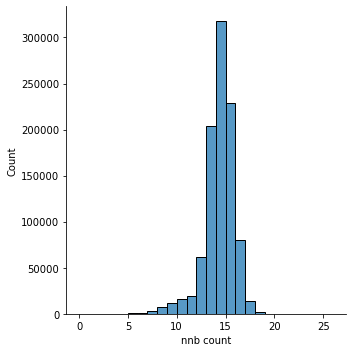

In [146]:
sns.displot(nnb_count, bins =range(27))

In [212]:
nnb_count.quantile(0.9999)

66.0

In [213]:
nnb_count.max()

72

In [215]:
from importlib import reload
reload(da)

<module 'data_analysis.static' from '/Users/zsolt/Colloid_git/TractionRheoscopy/data_analysis/static.py'>

In [216]:
%%time 
#how long does strain computation take with nnb cutoff of 3.5 and 72 neighbors?
strain_largeDistance = da.makeLocalStrainTraj(sedPos_rot, refCur, 3.5, output='frameParticle', pos_keys={'x':'x (um, rheo_sedHeight)', 'y': 'y (um, rheo_sedHeight)', 'z': 'z (um, rheo_sedHeight)'})

CPU times: user 6min 7s, sys: 8.01 s, total: 6min 15s
Wall time: 6min 15s


In [217]:
strain_largeDistance

values            D2_min       exx       exy       exz       eyy       eyz  \
frame particle                                                               
(0,1) 0         0.400048 -0.000623 -0.002726  0.005260 -0.007799  0.005197   
      1         0.191277  0.000630  0.006107  0.006455  0.002296 -0.005056   
      4         0.160029 -0.002299  0.002665 -0.005438 -0.007220  0.004388   
      5         0.136068 -0.000934  0.001082  0.001977 -0.000505  0.005817   
      6         0.281464  0.005376 -0.006306  0.013583  0.008348 -0.006566   
...                  ...       ...       ...       ...       ...       ...   
(0,5) 966611    0.344443  0.001276 -0.000927  0.005429 -0.000346  0.001919   
      966612    0.256123 -0.002260  0.000224  0.003597 -0.002495 -0.001852   
      966614    0.428462 -0.004998  0.000828  0.004139  0.000011 -0.004395   
      966616    0.350933  0.002845  0.000655  0.002292  0.002620  0.001416   
      966620    1.227850 -0.004574 -0.004207 -0.017909  0.001523 -0.009818   

values               ezz  nnb count       rxy       rxz       ryz  
frame particle                                                     
(0,1) 0         0.005489       18.0 -0.002865  0.001319  0.011155  
      1         0.008562       18.0  0.003701 -0.009107  0.003620  
      4         0.007206       20.0 -0.001760  0.001712 -0.001829  
      5        -0.008087       22.0  0.001033  0.001013 -0.003297  
      6         0.009758       22.0 -0.003750  0.009292 -0.000679  
...                  ...        ...       ...       ...       ...  
(0,5) 966611   -0.002409       59.0  0.001097  0.002871 -0.002781  
      966612    0.001776       57.0 -0.001731  0.003146 -0.000191  
      966614    0.000849       58.0 -0.002792 -0.000912 -0.005618  
      966616    0.006377       30.0 -0.001454  0.009594 -0.008919  
      966620   -0.032995       20.0  0.006597  0.023000 -0.007754  

[1917041 rows x 11 columns]

In [220]:
from matplotlib import pyplot as plt

(-0.01, 0.01)

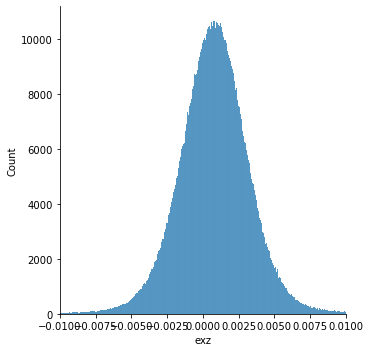

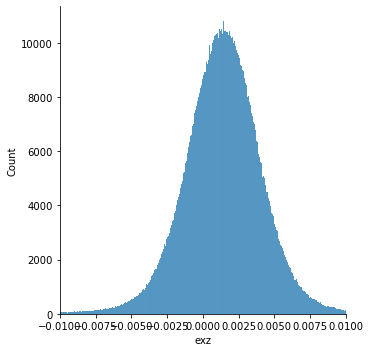

In [225]:
sns.displot(strain_largeDistance.xs('(0,1)', level='frame')['exz'])
plt.xlim(-0.01,0.01)
sns.displot(strain_largeDistance.xs('(0,5)', level='frame')['exz'])
plt.xlim(-0.01,0.01)

In [166]:
%%time
# what about querying for N closest neighbors?
# and keeping track of furthest point and avg distance? Or some other easy way of relating back to rdf short of listing distances 
# or number of neighbors closer or further than 2nd min in rdf
nnb_12_idx = tree.query(sedPos_rot_t0_np,k=17)

CPU times: user 3.85 s, sys: 86.2 ms, total: 3.93 s
Wall time: 3.93 s


In [168]:
nnb_12_idx[1][23232]

array([23232, 17179, 18407, 23335, 23469, 17920, 17787, 17230, 17229,
       17390, 18028, 18295, 23263, 17181, 17664, 17312, 24840])

In [172]:
tmp = nnb_12_idx[0]

In [179]:
tmp.shape

(966621, 17)

In [180]:
((tmp[:] > 1.7) & (tmp[:] < 2.2)).sum(axis=1)

In [183]:
# list of number of nearest neighbors within distance of 2.2
(nnb_12_idx[0][:] <2.2).sum(axis=1)

array([ 5,  6,  5, ..., 11, 12, 10])

In [182]:
# We could get the avg distance of the the first shell

array([ 5,  6,  5, ..., 11, 12, 10])

### [ ] decompose into para/perp strain by rotating the computed strain tensor

2

# SCRATCH

In [8]:
87508017/90

972311.3

In [226]:
118/22

5.363636363636363